Find multifault ruptures in RSQsim catalogue and investigate which faults are involved.
Compare initiation of multifault ruptures to slip rates.

In [ ]:
import matplotlib.pyplot as plt
from rsqsim_api.fault.multifault import RsqSimMultiFault
import shutil
from rsqsim_api.catalogue.catalogue import RsqSimCatalogue
import os
import numpy as np
import pandas as pd

seconds_per_year = 31557600.0

In [2]:
# # Tell python where field paths etc are relative to
script_dir = os.path.abspath('')
fault_dir = "../../../data/shaw2021/rundir5091"
catalogue_dir = fault_dir
#give directory to write multifault catalogue too / read from
multi_cat_dir="../../../data/shaw2021/multifault/"
#prefix of multifault catalogue file (takes a minute or so to filter whole catalogue)
multi_cat_name="multi_cat"

Read in catalogue of RSQsim events and fault model

In [3]:
fault_model = RsqSimMultiFault.read_fault_file_bruce(os.path.join(script_dir, fault_dir, "zfault_Deepen.in"),
                                                     os.path.join(script_dir, fault_dir, "znames_Deepen.in"),
                                                     transform_from_utm=True)
whole_catalogue = RsqSimCatalogue.from_catalogue_file_and_lists(os.path.join(catalogue_dir, "eqs..out"),
                                                                list_file_directory=catalogue_dir, list_file_prefix="catalog")


Read in catalogue of multifault ruptures or find multifault ruptures in the whole catalogue.

In [4]:
if os.path.exists(os.path.join(multi_cat_dir,multi_cat_name)):
    multi_cat=RsqSimCatalogue.from_csv_and_arrays(prefix=multi_cat_dir+multi_cat_name)
    multifault=[ev for ev in multi_cat.all_events(fault_model)]
else:
    # identify multifault events if not already read in
    multifault=[ev for ev in whole_catalogue.all_events(fault_model) if ev.num_faults > 1]
    #and filter catalogue to just these events 
    multifault_ids=[event.event_id for event in multifault]
    multi_cat=whole_catalogue.filter_by_events(multifault_ids)
    #write out
    multi_cat.write_csv_and_arrays(prefix=multi_cat_name,directory=multi_cat_dir)

Find number of events in whole catalogue, time span and proportion which are multifault.

In [212]:
#catalogue info
nevents=len(whole_catalogue.event_list)
timeSpan=(np.max(whole_catalogue.patch_time_list) - np.min (whole_catalogue.patch_time_list))/seconds_per_year
nmultifault=len(multifault)
prop_multifault=nmultifault/nevents
#write out
print('Catalogue contains {:,} events over {:,.0f} years.\n{:,} ({:.2f}%) of these are multifault ruptures'.format(nevents, timeSpan,nmultifault,prop_multifault*100.))

Catalogue contains 61,322,247 events over 276,581 years.
94,010 (0.15%) of these are multifault ruptures


In [6]:
#create dictionary of faults in each multifault event

#minimulti=multifault[10:100]
fault_dic={}
i=0
#for ev in minimulti:
for ev in multifault:
    ev_faults=fault_model.filter_faults_by_patch_numbers(ev.patch_numbers)
    ev_fault_names=ev_faults.names
    #find starting fault
    assert len(np.where(ev.patch_time==ev.patch_time.min())) == 1, "Event starts on multiple patches"
    firstPatch=ev.patch_numbers[np.argmin(ev.patch_time)]
    firstFault=ev_faults.filter_faults_by_patch_numbers(firstPatch,fault_from_single_patch=True)
    firstFaultName=firstFault.name
    #write dict entry
    fault_dic[i]=(ev.event_id,ev,len(ev_fault_names),ev_fault_names,firstFaultName)
    i=i+1
multifault_db=pd.DataFrame.from_dict(fault_dic,orient='index',columns=('Event_id','Event','N_faults','Fault_names','Start_fault'))

In [7]:
#sort by number of faults involved
multifault_db.sort_values(by=['N_faults'],axis=0,inplace=True)

In [209]:
# example of search for events with constraints on numbers of faults
two_faults=multifault_db.loc[multifault_db['N_faults']==2]
more_faults=multifault_db.loc[multifault_db['N_faults']>4]
most_faults=multifault_db.loc[multifault_db['N_faults']==np.max(multifault_db['N_faults'])]

In [211]:
# print some associated information
print('{:,} events  ({:.1f}% of multifault ruptures)  involve 2 faults.\n'
      '{:,} events ({:.1f}% of multifault ruptures)  involve 5 or more faults. \n The maximum number of faults involved is {} in a Mw {:.2f} earthquake (there are {} faults in the model).'.\
      format(len(two_faults),100.*len(two_faults)/nmultifault,len(more_faults),100.*len(more_faults)/nmultifault,np.max(multifault_db['N_faults']),most_faults['Event'].iloc[0].mw,len(fault_model.faults)))

67,990 events  (72.3% of multifault ruptures)  involve 2 faults.
7,336 events (7.8% of multifault ruptures)  involve 5 or more faults. 
 The maximum number of faults involved is 188 in a Mw 9.06 earthquake (there are 528 faults in the model).


Investigate multifault events including or starting on a specific fault e.g. hundalee (alpiner is a good test because have lots of these)

In [186]:
faultName='alpiner'
#access list of lists of fault names
fault_list=[multifault_db['Fault_names'].values[i] for i in np.arange(0,len(multifault_db['Fault_names'].values))]
#find the instances which contain the fault of interest
fault_events=[fault_list[i] for i in np.where([faultName in fault_list[j] for j in np.arange(0,len(fault_list))])[0]]
#find multifault events starting on the fault of interest
fault_start_events=multifault_db.loc[multifault_db['Start_fault']==faultName]

In [187]:
#write out findings
print('{} fault participates in {} multifault ruptures, with {} unique combinations.\n {} ({:.1f}%) of these multifault ruptures start on this fault.'.\
      format(faultName,len(fault_events),len(np.unique(np.asanyarray(fault_events,dtype=object))),len(fault_start_events),100.*len(fault_start_events)/len(fault_events)))

alpiner fault participates in 12704 multifault ruptures, with 105 unique combinations.
 10138 (79.8%) of these multifault ruptures start on this fault.


Look at how many multifault ruptures start on $\textbf{each}$ fault

In [31]:
# cumulative number of events starting on each fault
start_fault_by_nevents=multifault_db['Start_fault'].value_counts(sort=True)

Want to compare these multifault rupture initiations to fault slip rates - so make a dictionary of fault slip rates.

In [101]:
slip_rate_dict={}

for fault in fault_model.faults:
    all_slip_rates=[]
    for patch_id in fault.patch_numbers:
        patch = fault.patch_dic[patch_id]
        slip_rate = patch.total_slip
        all_slip_rates.append(slip_rate)
    #mean slip rate in mm/yr
    mean_slip_rate=np.mean(all_slip_rates)*seconds_per_year*1000
    if fault.name in start_fault_by_nevents.keys():
        slip_rate_dict[fault.name]=[mean_slip_rate,start_fault_by_nevents[fault.name]]
    else:
        slip_rate_dict[fault.name]=[mean_slip_rate,0]

... and plot

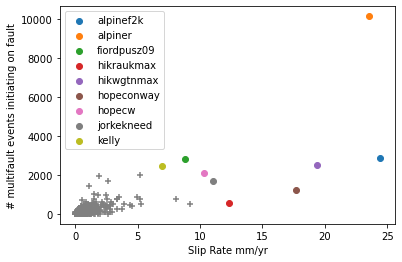

In [175]:
fig,ax=plt.subplots()

fault_names,points=zip(*slip_rate_dict.items())
x,y=zip(*points)

x=np.array(x)
y=np.array(y)
label_mask=(x<10) * (y<2000)
x_no_label=x[label_mask]
y_no_label=y[label_mask]
ax.scatter(x_no_label,y_no_label,marker="+",c="grey")
#and plot higher values which we do want to label
x_label=x[~label_mask]
y_label=y[~label_mask]
fault_names=np.array(fault_names)
fault_labels=fault_names[~label_mask]

for label in fault_labels:
    index=np.where(fault_labels==label)
    ax.scatter(x_label[index],y_label[index],label=label)

#for i, txt in enumerate(fault_labels):
#    plt.annotate(txt,(x_label[i],y_label[i]))
plt.legend()
ax.set_xlabel("Slip Rate mm/yr")
ax.set_ylabel("# multifault events initiating on fault")
fig.savefig("multi_init-slip_rate.jpg",dpi=300)

Next steps:
* look at total number of ruptures and / or multifault ruptures involving each fault
* look at what multifault ruptures are happening (i.e. which faults are involved)
* these would probably be easier if had fault_events as an RSQsimCatalogue object - how to do this?
* Does number of faults involved correlate with event magnitude?